In [ ]:
!pip install datasets==3.3.2

Looking in indexes: https://mirrors.bfsu.edu.cn/pypi/web/simple
  Using cached https://mirrors.bfsu.edu.cn/pypi/web/packages/4c/37/22ef7675bef4ffe9577b937ddca2e22791534cbbe11c30714972a91532dc/datasets-3.3.2-py3-none-any.whl (485 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sae-lens 5.10.3 requires datasets<3.0.0,>=2.17.1, but you have datasets 3.3.2 which is incompatible.
sae-lens 5.10.3 requires zstandard<0.23.0,>=0.22.0, but you have zstandard 0.23.0 which is incompatible.


In [17]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoModelForCausalLM, GPT2Config,Qwen2Config, set_seed
from datasets import load_dataset
from typing import Dict, Any, Optional
set_seed(0)

In [2]:
from typing import List, Tuple, Union
import torch
from torch.utils.data import Dataset

class PixelSequenceDataset(Dataset):
    def __init__(self, data: List[List[int]], mode: str = "train"):
        """
        A dataset class for handling pixel sequences.

        Args:
            data (List[List[int]]): A list of sequences, where each sequence is a list of integers.
            mode (str): The mode of operation, either "train", "dev", or "test".
                - "train": Returns (input_ids, labels) where input_ids are sequence[:-1] and labels are sequence[1:].
                - "dev": Returns (input_ids, labels) where input_ids are sequence[:-160] and labels are sequence[-160:].
                - "test": Returns only input_ids, as labels are not available.
        """
        self.data = data
        self.mode = mode

    def __len__(self) -> int:
        """Returns the total number of sequences in the dataset."""
        return len(self.data)

    def __getitem__(self, idx: int) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Fetches a sequence from the dataset and processes it based on the mode.

        Args:
            idx (int): The index of the sequence.

        Returns:
            - If mode == "train": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "dev": Tuple[torch.Tensor, torch.Tensor] -> (input_ids, labels)
            - If mode == "test": torch.Tensor -> input_ids
        """
        sequence = self.data[idx]

        if self.mode == "train":
            input_ids = torch.tensor(sequence[:-1], dtype=torch.long)
            labels = torch.tensor(sequence[1:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "dev":
            input_ids = torch.tensor(sequence[:-160], dtype=torch.long)
            labels = torch.tensor(sequence[-160:], dtype=torch.long)
            return input_ids, labels

        elif self.mode == "test":
            input_ids = torch.tensor(sequence, dtype=torch.long)
            return input_ids

        raise ValueError(f"Invalid mode: {self.mode}. Choose from 'train', 'dev', or 'test'.")

In [3]:
# Load the pokemon dataset from Hugging Face Hub
pokemon_dataset = load_dataset("lca0503/ml2025-hw4-pokemon")

# Load the colormap from Hugging Face Hub
colormap = list(load_dataset("lca0503/ml2025-hw4-colormap")["train"]["color"])

# Define number of classes
num_classes = len(colormap)

# Define batch size
batch_size = 16

# === Prepare Dataset and DataLoader for Training ===
train_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["train"]["pixel_color"], mode="train"
)
train_dataloader: DataLoader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

# === Prepare Dataset and DataLoader for Validation ===
dev_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["dev"]["pixel_color"], mode="dev"
)
dev_dataloader: DataLoader = DataLoader(
    dev_dataset, batch_size=batch_size, shuffle=False
)

# === Prepare Dataset and DataLoader for Testing ===
test_dataset: PixelSequenceDataset = PixelSequenceDataset(
    pokemon_dataset["test"]["pixel_color"], mode="test"
)
test_dataloader: DataLoader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

README.md:   0%|          | 0.00/501 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [4]:
def pixel_to_image(pixel_color: List[int], colormap: List[List[int]]) -> Image.Image:
    """
    Converts a list of pixel indices into a 20x20 RGB image using a colormap.

    Args:
        pixel_color (List[int]): A list of pixel indices representing colors.
        colormap (List[List[int]]): A list where each index maps to an RGB color [R, G, B].

    Returns:
        Image.Image: A PIL Image object representing the reconstructed image.
    """
    # Ensure the pixel_color list has at least 400 elements (pad with 0s if needed)
    while len(pixel_color) < 400:
        pixel_color.append(0)

    # Map pixel indices to actual RGB colors using the colormap
    pixel_data = [colormap[pixel] for pixel in pixel_color]

    # Convert to numpy array and reshape to 20x20x3 (RGB image)
    image_array = np.array(pixel_data, dtype=np.uint8).reshape(20, 20, 3)

    # Create a PIL Image from the array
    image = Image.fromarray(image_array)

    return image

def show_images(images: List[Image.Image]) -> None:
    """
    Displays a grid of up to 96 images using Matplotlib.

    Args:
        images (List[Image.Image]): A list of PIL Image objects to display.

    Returns:
        None
    """
    num_images = min(96, len(images))  # Limit to 96 images

    # Set up the figure size and grid layout (6 rows, 16 columns)
    fig, axes = plt.subplots(6, 16, figsize=(16, 6))
    axes = axes.flatten()  # Flatten to make iteration easier

    # Loop through images and display each one in the grid
    for i, ax in enumerate(axes):
        if i < num_images:
            ax.imshow(images[i])
            ax.axis('off')  # Hide axis
        else:
            ax.axis('off')  # Hide unused subplots

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

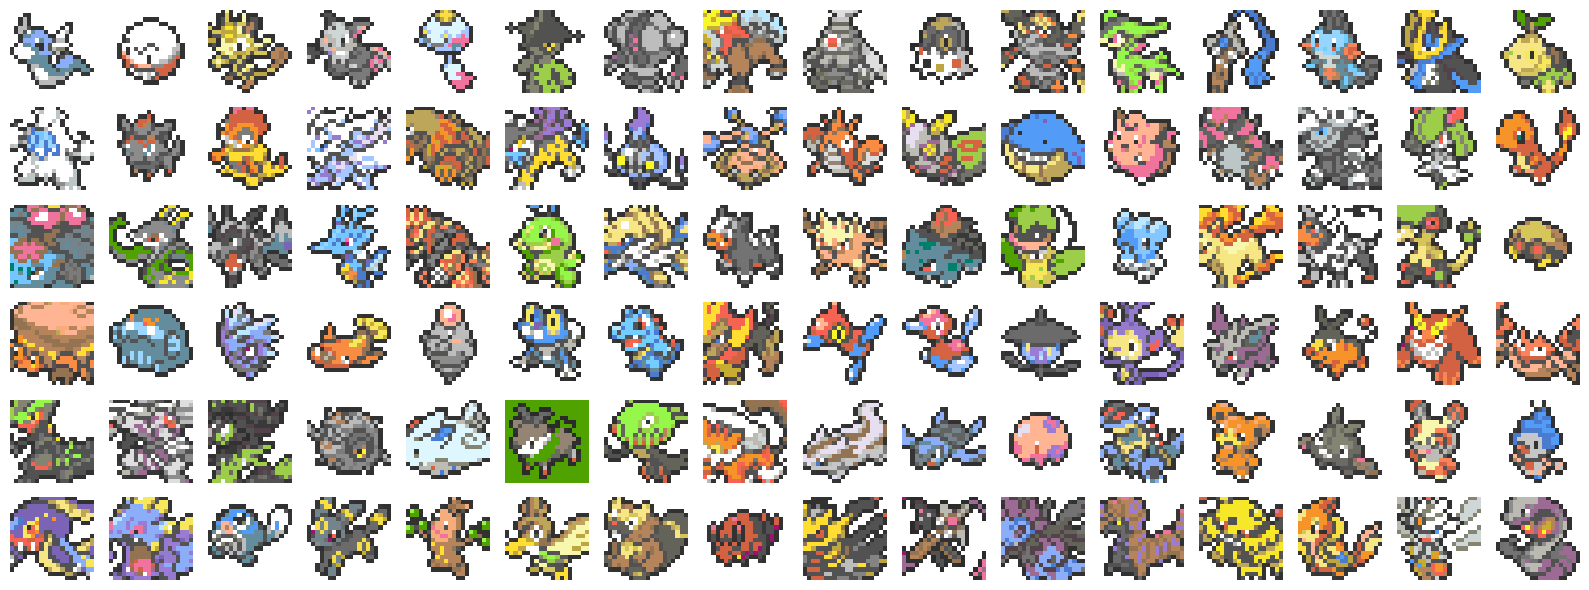

In [5]:
# Visualize train images
train_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["train"]]
show_images(train_images)

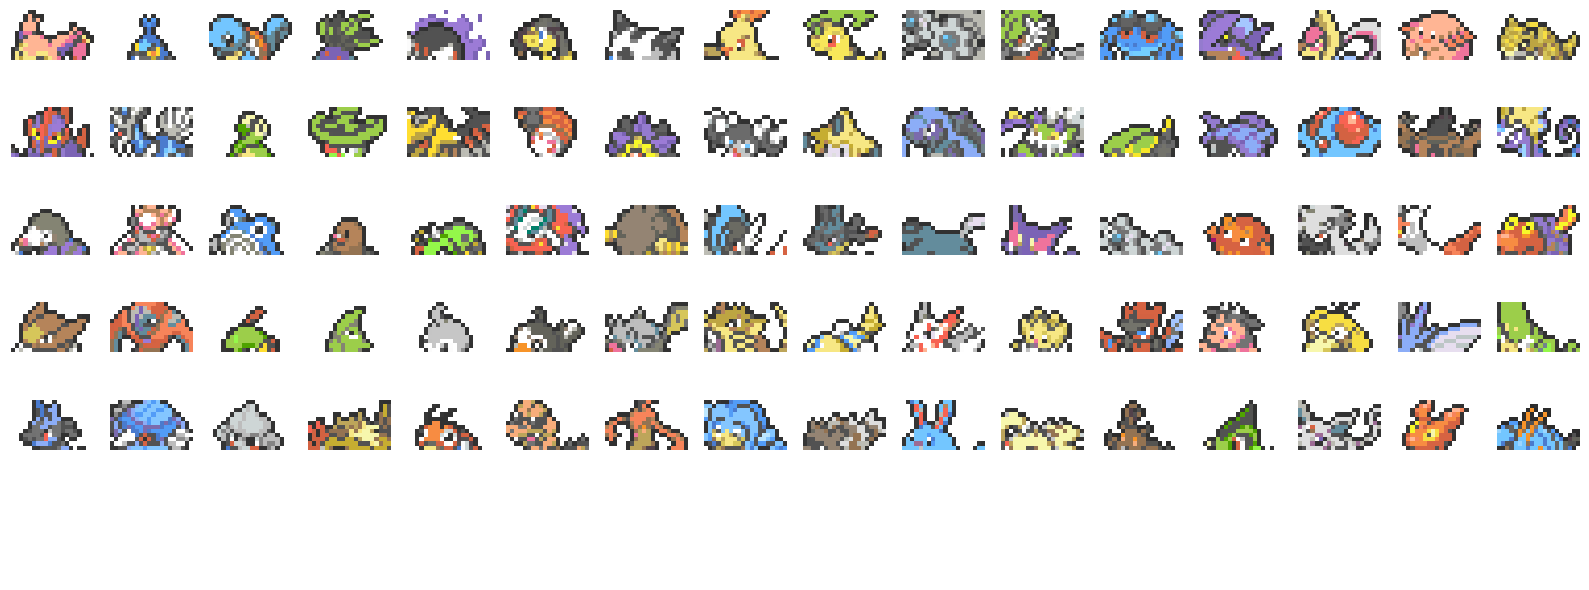

In [6]:
 #isualize test images
test_images = [pixel_to_image(data["pixel_color"], colormap) for data in pokemon_dataset["test"]]
show_images(test_images)

In [ ]:
# Define GPT-2 model configuration as a dictionary
gpt2_config = {
    "activation_function": "gelu_new",    # Activation function used in the model
    "architectures": ["GPT2LMHeadModel"],  # Specifies the model type
    "attn_pdrop": 0.1,            # Dropout rate for attention layers
    "embd_pdrop": 0.1,            # Dropout rate for embeddings
    "initializer_range": 0.02,        # Standard deviation for weight initialization
    "layer_norm_epsilon": 1e-05,       # Small constant to improve numerical stability in layer norm
    "model_type": "gpt2",           # Type of model
    "n_ctx": 128,               # Context size (maximum sequence length)
    "n_embd": 64,              # Embedding size
    "n_head": 2,               # Number of attention heads
    "n_layer": 2,              # Number of transformer layers
    "n_positions": 400,           # Maximum number of token positions
    "resid_pdrop": 0.1,           # Dropout rate for residual connections
    "vocab_size": num_classes,       # Number of unique tokens in vocabulary
    "pad_token_id": None,          # Padding token ID (None means no padding token)
    "eos_token_id": None,          # End-of-sequence token ID (None means not explicitly defined)
}

# Load GPT-2 model configuration from dictionary
config = GPT2Config.from_dict(gpt2_config)


## 这里我把模型换成了Qwen2
原来config下的GPT2的loss只能训到1.3，qwen2一下就干到0.8了，效果好了很多

In [ ]:


qwen2_config = {
    "architectures": ["Qwen2Model"],  # Specifies the model type
    "hidden_size": 64,              # Size of the hidden layers
    "num_hidden_layers": 4,         # Number of transformer layers
    "num_attention_heads": 8,       # Number of attention heads
    "num_key_value_heads":8,       # Number of attention heads
    "intermediate_size": 256,       # Size of the intermediate (feed-forward) layer
    "hidden_act": "gelu",           # Activation function used in the model
    "vocab_size": num_classes,      # Number of unique tokens in vocabulary
    "max_position_embeddings": 400, # Maximum number of token positions
    "type_vocab_size": 1,           # Size of token type vocabulary (usually 1 for single sequence tasks)
    "initializer_range": 0.02,      # Standard deviation for weight initialization
}

config = Qwen2Config.from_dict(qwen2_config)
    

In [69]:
# Load the model using the configuration defined above
model = AutoModelForCausalLM.from_config(config)

print(model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {trainable_params:,}")

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(167, 64)
    (layers): ModuleList(
      (0-3): 4 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=64, out_features=64, bias=True)
          (k_proj): Linear(in_features=64, out_features=64, bias=True)
          (v_proj): Linear(in_features=64, out_features=64, bias=True)
          (o_proj): Linear(in_features=64, out_features=64, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=64, out_features=256, bias=False)
          (up_proj): Linear(in_features=64, out_features=256, bias=False)
          (down_proj): Linear(in_features=256, out_features=64, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): Qwen2RMSNorm((64,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((64,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((64,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbedding()
  )
 

In [70]:
# Training Parameters
epochs = 50                                      # Number of training epochs
learning_rate = 1e-3                                 # Learning rate for optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")     # Check if CUDA is available for GPU
save_dir = "checkpoints"                               # Directory to save model checkpoints

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()                          # Loss function for classification tasks
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1) # AdamW optimizer with weight decay

In [71]:
def save_model(model: torch.nn.Module, optimizer: torch.optim.Optimizer, epoch: int, loss: float, save_dir: str, filename: str = "best_model.pth") -> None:
    """
    Saves the model state, optimizer state, current epoch, and loss to a specified directory.

    Args:
        model (torch.nn.Module): The PyTorch model to be saved.
        optimizer (torch.optim.Optimizer): The optimizer whose state will be saved.
        epoch (int): The current epoch number (used for checkpointing).
        loss (float): The current loss value to track model performance.
        save_dir (str): The directory where the model checkpoint will be saved.
        filename (str, optional): The name of the file to save the model. Defaults to "best_model.pth".

    Returns:
        None
    """
    # Construct the full path for saving the model checkpoint
    save_path = os.path.join(save_dir, filename)

    # Save the model, optimizer state, and additional metadata (epoch and loss)
    torch.save({
        'epoch': epoch + 1,                # Save epoch + 1 for easier tracking
        'model_state_dict': model.state_dict(),       # Save model weights
        'optimizer_state_dict': optimizer.state_dict(),  # Save optimizer state (important for resuming training)
        'loss': loss                     # Save the current loss value
    }, save_path)

    # Print a confirmation message indicating the model has been saved
    print(f"Model saved at {save_path} (Loss: {loss:.4f}, Epoch: {epoch + 1})")

In [72]:
# Create save directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
# Initialize best loss as positive infinity for comparison during model checkpointing
best_loss: float = float('inf')
# Move model to the appropriate device (GPU or CPU)
model.to(device)

# Training Loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize the epoch loss

    # Iterate over training data batches
    for input_ids, labels in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        input_ids, labels = input_ids.to(device), labels.to(device)  # Move data to the same device as the model

        # Forward pass through the model to get logits (output probabilities)
        outputs = model(input_ids=input_ids).logits.view(-1, config.vocab_size)
        labels = labels.view(-1)  # Flatten labels to match logits shape

        # Calculate loss using CrossEntropyLoss
        loss = criterion(outputs, labels)

        # Backpropagation and optimizer step
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()     # Compute gradients
        optimizer.step()     # Update model weights

        # Accumulate the loss for the epoch
        epoch_loss += loss.item()

    # Compute average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

    # Evaluation Loop (Validation)
    model.eval()      # Set the model to evaluation mode (disables dropout, etc.)
    total_accuracy = 0  # Initialize total accuracy
    num_batches = 0   # Initialize batch counter

    with torch.no_grad():  # Disable gradient calculation for validation
        # Iterate over validation data batches
        for inputs, labels in tqdm(dev_dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)  # Move validation data to device
            attention_mask = torch.ones_like(inputs)          # Attention mask to ensure valid token positions

            # Perform batch inference using the model
            generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

            # Extract the last 160 tokens from generated outputs and labels
            generated_outputs = generated_outputs[:, -160:]

            # Calculate accuracy for the batch
            accuracy = (generated_outputs == labels).float().mean().item()
            total_accuracy += accuracy
            num_batches += 1

    # Compute average reconstruction accuracy for the epoch
    avg_accuracy = total_accuracy / num_batches
    print(f"Epoch {epoch + 1}/{epochs}, Reconstruction Accuracy: {avg_accuracy:.4f}")

    # If the current epoch loss is better (lower) than the best loss, save the model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss                   # Update best loss
        save_model(model, optimizer, epoch, best_loss, save_dir)  # Save the model with the best loss

Training Epoch 1/50:   0%|          | 0/40 [00:00<?, ?it/s]

Training Epoch 1/50: 100%|██████████| 40/40 [00:00<00:00, 111.07it/s]


Epoch 1/50, Loss: 3.9726


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 1/50, Reconstruction Accuracy: 0.3785
Model saved at checkpoints/best_model.pth (Loss: 3.9726, Epoch: 1)


Training Epoch 2/50: 100%|██████████| 40/40 [00:00<00:00, 117.10it/s]


Epoch 2/50, Loss: 2.9630


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 2/50, Reconstruction Accuracy: 0.3659
Model saved at checkpoints/best_model.pth (Loss: 2.9630, Epoch: 2)


Training Epoch 3/50: 100%|██████████| 40/40 [00:00<00:00, 117.16it/s]


Epoch 3/50, Loss: 2.5603


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 3/50, Reconstruction Accuracy: 0.3622
Model saved at checkpoints/best_model.pth (Loss: 2.5603, Epoch: 3)


Training Epoch 4/50: 100%|██████████| 40/40 [00:00<00:00, 117.22it/s]


Epoch 4/50, Loss: 2.2884


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 4/50, Reconstruction Accuracy: 0.3427
Model saved at checkpoints/best_model.pth (Loss: 2.2884, Epoch: 4)


Training Epoch 5/50: 100%|██████████| 40/40 [00:00<00:00, 117.19it/s]


Epoch 5/50, Loss: 2.0739


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 5/50, Reconstruction Accuracy: 0.2231
Model saved at checkpoints/best_model.pth (Loss: 2.0739, Epoch: 5)


Training Epoch 6/50: 100%|██████████| 40/40 [00:00<00:00, 117.26it/s]


Epoch 6/50, Loss: 1.9117


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 6/50, Reconstruction Accuracy: 0.1887
Model saved at checkpoints/best_model.pth (Loss: 1.9117, Epoch: 6)


Training Epoch 7/50: 100%|██████████| 40/40 [00:00<00:00, 116.70it/s]


Epoch 7/50, Loss: 1.7880


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 7/50, Reconstruction Accuracy: 0.2690
Model saved at checkpoints/best_model.pth (Loss: 1.7880, Epoch: 7)


Training Epoch 8/50: 100%|██████████| 40/40 [00:00<00:00, 114.96it/s]


Epoch 8/50, Loss: 1.6910


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 8/50, Reconstruction Accuracy: 0.3268
Model saved at checkpoints/best_model.pth (Loss: 1.6910, Epoch: 8)


Training Epoch 9/50: 100%|██████████| 40/40 [00:00<00:00, 117.15it/s]


Epoch 9/50, Loss: 1.6266


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 9/50, Reconstruction Accuracy: 0.2794
Model saved at checkpoints/best_model.pth (Loss: 1.6266, Epoch: 9)


Training Epoch 10/50: 100%|██████████| 40/40 [00:00<00:00, 117.07it/s]


Epoch 10/50, Loss: 1.5725


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 10/50, Reconstruction Accuracy: 0.2437
Model saved at checkpoints/best_model.pth (Loss: 1.5725, Epoch: 10)


Training Epoch 11/50: 100%|██████████| 40/40 [00:00<00:00, 116.65it/s]


Epoch 11/50, Loss: 1.5263


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 11/50, Reconstruction Accuracy: 0.3450
Model saved at checkpoints/best_model.pth (Loss: 1.5263, Epoch: 11)


Training Epoch 12/50: 100%|██████████| 40/40 [00:00<00:00, 117.03it/s]


Epoch 12/50, Loss: 1.4792


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 12/50, Reconstruction Accuracy: 0.3059
Model saved at checkpoints/best_model.pth (Loss: 1.4792, Epoch: 12)


Training Epoch 13/50: 100%|██████████| 40/40 [00:00<00:00, 116.94it/s]


Epoch 13/50, Loss: 1.4532


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 13/50, Reconstruction Accuracy: 0.3063
Model saved at checkpoints/best_model.pth (Loss: 1.4532, Epoch: 13)


Training Epoch 14/50: 100%|██████████| 40/40 [00:00<00:00, 117.17it/s]


Epoch 14/50, Loss: 1.4287


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 14/50, Reconstruction Accuracy: 0.3623
Model saved at checkpoints/best_model.pth (Loss: 1.4287, Epoch: 14)


Training Epoch 15/50: 100%|██████████| 40/40 [00:00<00:00, 117.40it/s]


Epoch 15/50, Loss: 1.3943


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 15/50, Reconstruction Accuracy: 0.3507
Model saved at checkpoints/best_model.pth (Loss: 1.3943, Epoch: 15)


Training Epoch 16/50: 100%|██████████| 40/40 [00:00<00:00, 117.21it/s]


Epoch 16/50, Loss: 1.3706


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 16/50, Reconstruction Accuracy: 0.3562
Model saved at checkpoints/best_model.pth (Loss: 1.3706, Epoch: 16)


Training Epoch 17/50: 100%|██████████| 40/40 [00:00<00:00, 116.55it/s]


Epoch 17/50, Loss: 1.3473


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 17/50, Reconstruction Accuracy: 0.3459
Model saved at checkpoints/best_model.pth (Loss: 1.3473, Epoch: 17)


Training Epoch 18/50: 100%|██████████| 40/40 [00:00<00:00, 117.04it/s]


Epoch 18/50, Loss: 1.3288


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 18/50, Reconstruction Accuracy: 0.3474
Model saved at checkpoints/best_model.pth (Loss: 1.3288, Epoch: 18)


Training Epoch 19/50: 100%|██████████| 40/40 [00:00<00:00, 116.28it/s]


Epoch 19/50, Loss: 1.3096


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 19/50, Reconstruction Accuracy: 0.3303
Model saved at checkpoints/best_model.pth (Loss: 1.3096, Epoch: 19)


Training Epoch 20/50: 100%|██████████| 40/40 [00:00<00:00, 116.24it/s]


Epoch 20/50, Loss: 1.2848


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 20/50, Reconstruction Accuracy: 0.3079
Model saved at checkpoints/best_model.pth (Loss: 1.2848, Epoch: 20)


Training Epoch 21/50: 100%|██████████| 40/40 [00:00<00:00, 115.65it/s]


Epoch 21/50, Loss: 1.2659


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


Epoch 21/50, Reconstruction Accuracy: 0.3220
Model saved at checkpoints/best_model.pth (Loss: 1.2659, Epoch: 21)


Training Epoch 22/50: 100%|██████████| 40/40 [00:00<00:00, 115.96it/s]


Epoch 22/50, Loss: 1.2507


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


Epoch 22/50, Reconstruction Accuracy: 0.3591
Model saved at checkpoints/best_model.pth (Loss: 1.2507, Epoch: 22)


Training Epoch 23/50: 100%|██████████| 40/40 [00:00<00:00, 116.17it/s]


Epoch 23/50, Loss: 1.2430


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 23/50, Reconstruction Accuracy: 0.3372
Model saved at checkpoints/best_model.pth (Loss: 1.2430, Epoch: 23)


Training Epoch 24/50: 100%|██████████| 40/40 [00:00<00:00, 116.41it/s]


Epoch 24/50, Loss: 1.2190


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 24/50, Reconstruction Accuracy: 0.3769
Model saved at checkpoints/best_model.pth (Loss: 1.2190, Epoch: 24)


Training Epoch 25/50: 100%|██████████| 40/40 [00:00<00:00, 116.61it/s]


Epoch 25/50, Loss: 1.2075


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 25/50, Reconstruction Accuracy: 0.3363
Model saved at checkpoints/best_model.pth (Loss: 1.2075, Epoch: 25)


Training Epoch 26/50: 100%|██████████| 40/40 [00:00<00:00, 115.82it/s]


Epoch 26/50, Loss: 1.1871


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 26/50, Reconstruction Accuracy: 0.3481
Model saved at checkpoints/best_model.pth (Loss: 1.1871, Epoch: 26)


Training Epoch 27/50: 100%|██████████| 40/40 [00:00<00:00, 116.36it/s]


Epoch 27/50, Loss: 1.1691


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


Epoch 27/50, Reconstruction Accuracy: 0.3683
Model saved at checkpoints/best_model.pth (Loss: 1.1691, Epoch: 27)


Training Epoch 28/50: 100%|██████████| 40/40 [00:00<00:00, 116.14it/s]


Epoch 28/50, Loss: 1.1618


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 28/50, Reconstruction Accuracy: 0.3567
Model saved at checkpoints/best_model.pth (Loss: 1.1618, Epoch: 28)


Training Epoch 29/50: 100%|██████████| 40/40 [00:00<00:00, 116.16it/s]


Epoch 29/50, Loss: 1.1402


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Epoch 29/50, Reconstruction Accuracy: 0.3679
Model saved at checkpoints/best_model.pth (Loss: 1.1402, Epoch: 29)


Training Epoch 30/50: 100%|██████████| 40/40 [00:00<00:00, 116.08it/s]


Epoch 30/50, Loss: 1.1212


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 30/50, Reconstruction Accuracy: 0.3386
Model saved at checkpoints/best_model.pth (Loss: 1.1212, Epoch: 30)


Training Epoch 31/50: 100%|██████████| 40/40 [00:00<00:00, 116.16it/s]


Epoch 31/50, Loss: 1.1156


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 31/50, Reconstruction Accuracy: 0.3413
Model saved at checkpoints/best_model.pth (Loss: 1.1156, Epoch: 31)


Training Epoch 32/50: 100%|██████████| 40/40 [00:00<00:00, 116.48it/s]


Epoch 32/50, Loss: 1.1116


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 32/50, Reconstruction Accuracy: 0.3550
Model saved at checkpoints/best_model.pth (Loss: 1.1116, Epoch: 32)


Training Epoch 33/50: 100%|██████████| 40/40 [00:00<00:00, 116.95it/s]


Epoch 33/50, Loss: 1.0859


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 33/50, Reconstruction Accuracy: 0.3850
Model saved at checkpoints/best_model.pth (Loss: 1.0859, Epoch: 33)


Training Epoch 34/50: 100%|██████████| 40/40 [00:00<00:00, 116.24it/s]


Epoch 34/50, Loss: 1.0730


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


Epoch 34/50, Reconstruction Accuracy: 0.3537
Model saved at checkpoints/best_model.pth (Loss: 1.0730, Epoch: 34)


Training Epoch 35/50: 100%|██████████| 40/40 [00:00<00:00, 116.38it/s]


Epoch 35/50, Loss: 1.0532


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 35/50, Reconstruction Accuracy: 0.3447
Model saved at checkpoints/best_model.pth (Loss: 1.0532, Epoch: 35)


Training Epoch 36/50: 100%|██████████| 40/40 [00:00<00:00, 116.48it/s]


Epoch 36/50, Loss: 1.0440


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.93it/s]


Epoch 36/50, Reconstruction Accuracy: 0.3376
Model saved at checkpoints/best_model.pth (Loss: 1.0440, Epoch: 36)


Training Epoch 37/50: 100%|██████████| 40/40 [00:00<00:00, 116.56it/s]


Epoch 37/50, Loss: 1.0423


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 37/50, Reconstruction Accuracy: 0.3657
Model saved at checkpoints/best_model.pth (Loss: 1.0423, Epoch: 37)


Training Epoch 38/50: 100%|██████████| 40/40 [00:00<00:00, 116.63it/s]


Epoch 38/50, Loss: 1.0286


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 38/50, Reconstruction Accuracy: 0.3726
Model saved at checkpoints/best_model.pth (Loss: 1.0286, Epoch: 38)


Training Epoch 39/50: 100%|██████████| 40/40 [00:00<00:00, 116.18it/s]


Epoch 39/50, Loss: 1.0057


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 39/50, Reconstruction Accuracy: 0.3667
Model saved at checkpoints/best_model.pth (Loss: 1.0057, Epoch: 39)


Training Epoch 40/50: 100%|██████████| 40/40 [00:00<00:00, 116.66it/s]


Epoch 40/50, Loss: 0.9924


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


Epoch 40/50, Reconstruction Accuracy: 0.3669
Model saved at checkpoints/best_model.pth (Loss: 0.9924, Epoch: 40)


Training Epoch 41/50: 100%|██████████| 40/40 [00:00<00:00, 116.81it/s]


Epoch 41/50, Loss: 0.9677


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


Epoch 41/50, Reconstruction Accuracy: 0.3439
Model saved at checkpoints/best_model.pth (Loss: 0.9677, Epoch: 41)


Training Epoch 42/50: 100%|██████████| 40/40 [00:00<00:00, 116.12it/s]


Epoch 42/50, Loss: 0.9710


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 42/50, Reconstruction Accuracy: 0.3716


Training Epoch 43/50: 100%|██████████| 40/40 [00:00<00:00, 116.52it/s]


Epoch 43/50, Loss: 0.9602


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 43/50, Reconstruction Accuracy: 0.3822
Model saved at checkpoints/best_model.pth (Loss: 0.9602, Epoch: 43)


Training Epoch 44/50: 100%|██████████| 40/40 [00:00<00:00, 116.18it/s]


Epoch 44/50, Loss: 0.9461


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 44/50, Reconstruction Accuracy: 0.3738
Model saved at checkpoints/best_model.pth (Loss: 0.9461, Epoch: 44)


Training Epoch 45/50: 100%|██████████| 40/40 [00:00<00:00, 116.75it/s]


Epoch 45/50, Loss: 0.9235


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.88it/s]


Epoch 45/50, Reconstruction Accuracy: 0.3279
Model saved at checkpoints/best_model.pth (Loss: 0.9235, Epoch: 45)


Training Epoch 46/50: 100%|██████████| 40/40 [00:00<00:00, 116.17it/s]


Epoch 46/50, Loss: 0.9119


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


Epoch 46/50, Reconstruction Accuracy: 0.3595
Model saved at checkpoints/best_model.pth (Loss: 0.9119, Epoch: 46)


Training Epoch 47/50: 100%|██████████| 40/40 [00:00<00:00, 116.55it/s]


Epoch 47/50, Loss: 0.9075


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 47/50, Reconstruction Accuracy: 0.3627
Model saved at checkpoints/best_model.pth (Loss: 0.9075, Epoch: 47)


Training Epoch 48/50: 100%|██████████| 40/40 [00:00<00:00, 116.31it/s]


Epoch 48/50, Loss: 0.8821


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


Epoch 48/50, Reconstruction Accuracy: 0.3388
Model saved at checkpoints/best_model.pth (Loss: 0.8821, Epoch: 48)


Training Epoch 49/50: 100%|██████████| 40/40 [00:00<00:00, 116.38it/s]


Epoch 49/50, Loss: 0.8809


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 49/50, Reconstruction Accuracy: 0.3711
Model saved at checkpoints/best_model.pth (Loss: 0.8809, Epoch: 49)


Training Epoch 50/50: 100%|██████████| 40/40 [00:00<00:00, 116.71it/s]


Epoch 50/50, Loss: 0.8657


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]

Epoch 50/50, Reconstruction Accuracy: 0.3585
Model saved at checkpoints/best_model.pth (Loss: 0.8657, Epoch: 50)


In [73]:
# Load the best model from the saved checkpoint
best_model_path = os.path.join(save_dir, "best_model.pth")              # Path to the best model checkpoint
checkpoint = torch.load(best_model_path, weights_only=True, map_location=device)  # Load checkpoint from the file
model.load_state_dict(checkpoint["model_state_dict"])                  # Load the model weights from checkpoint
model.eval()                                        # Set the model to evaluation mode (disables dropout, etc.)

# Testing Loop with Batch Inference
results: list = []  # List to store the generated sequences from the model

with torch.no_grad():  # Disable gradient calculations for inference
    # Iterate over test data in batches
    for inputs in tqdm(test_dataloader, desc="Generating Outputs"):
        inputs = inputs.to(device)         # Move model to the appropriate device (GPU or CPU)
        attention_mask = torch.ones_like(inputs)  # Attention mask (ensure valid token positions)

        # Generate predictions for the entire batch
        generated_outputs = model.generate(inputs, attention_mask=attention_mask, max_length=400)

        # Convert batch outputs to a list and append to results
        batch_results = generated_outputs.cpu().numpy().tolist()
        results.extend(batch_results)  # Extend the results list with batch results

# Save the results to a file
output_file: str = "reconstructed_results.txt"  # File to save the output sequences
with open(output_file, "w") as f:
    # Write each sequence to the file
    for seq in results:
        f.write(" ".join(map(str, seq)) + "\n")

print(f"Reconstructed results saved to {output_file}")  # Confirmation message

Generating Outputs:   0%|          | 0/5 [00:00<?, ?it/s]

Generating Outputs: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]

Reconstructed results saved to reconstructed_results.txt


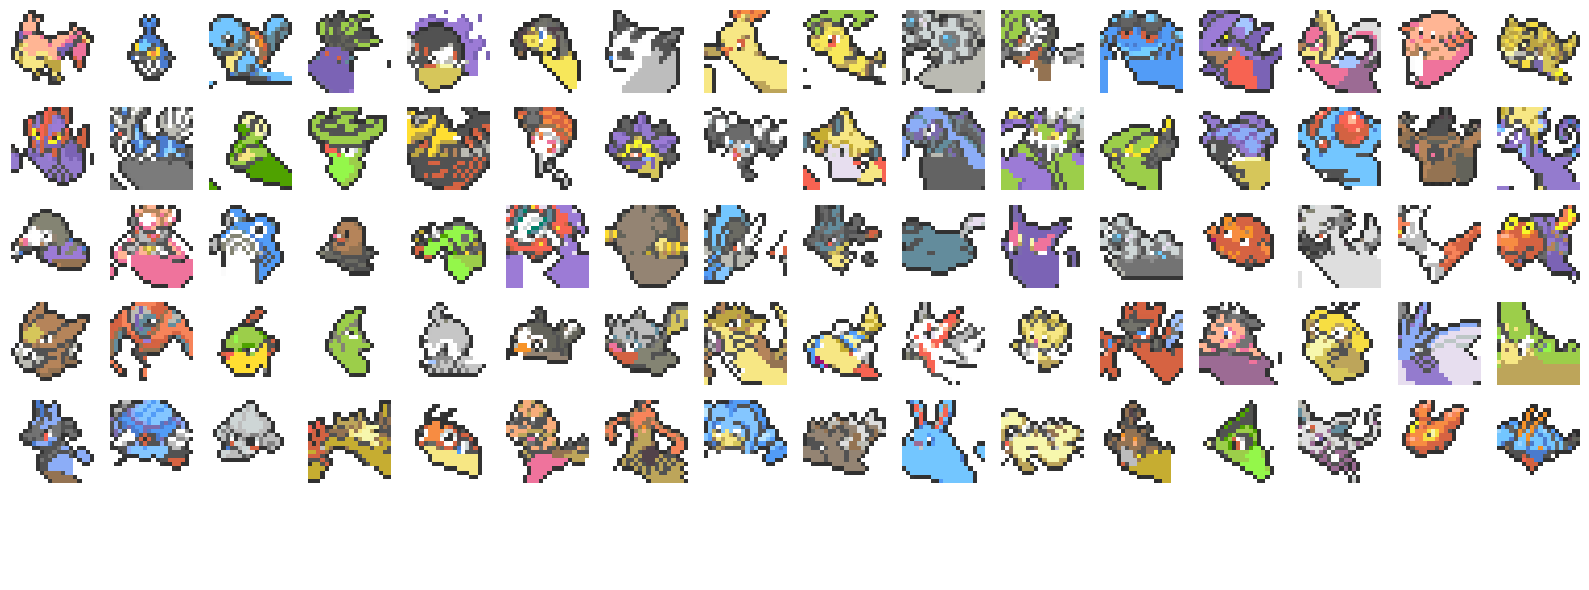

In [74]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)

### 作为对比，下面是默认config下GPT2模型生成的

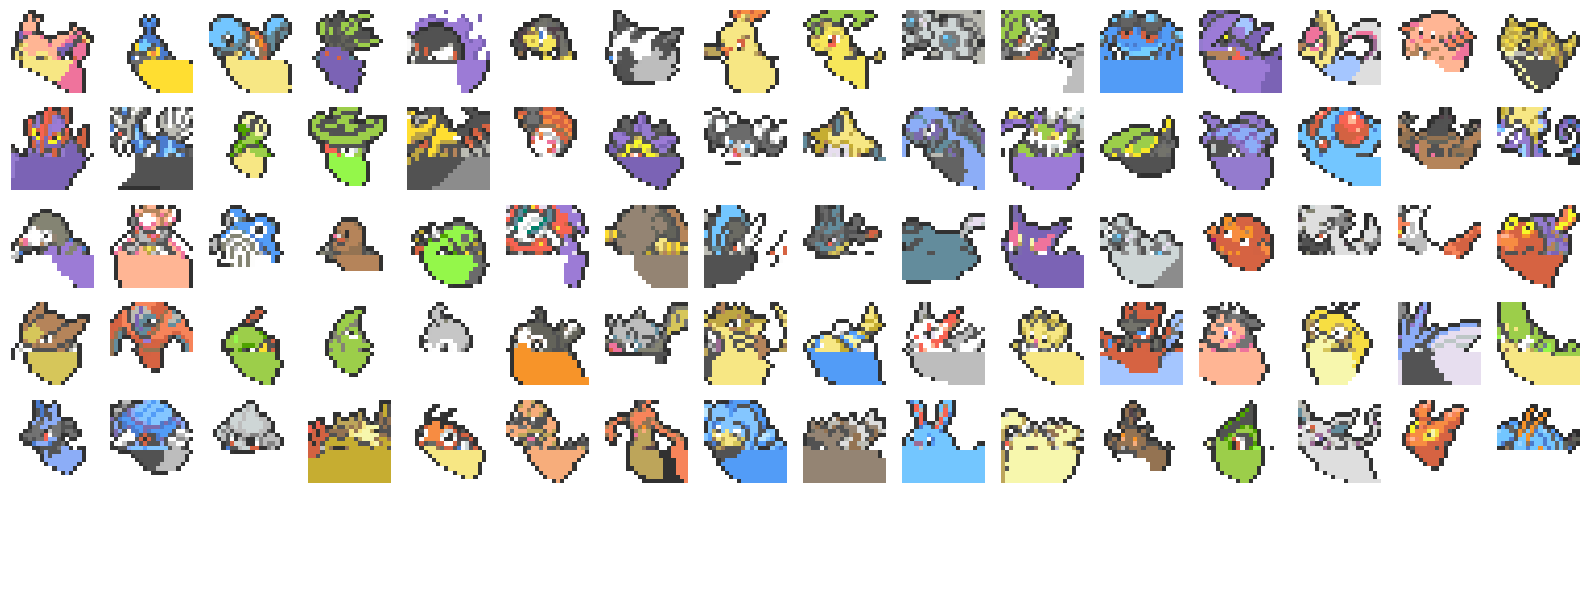

In [ ]:
# Visualize generated test images
predicted_images = [pixel_to_image(sequence, colormap) for sequence in results]
show_images(predicted_images)